In [1]:
import numpy as np
from numpy import random
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFTGate
from qiskit.circuit.library import QFT
from qiskit.circuit.library import PhaseGate
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
import qiskit.quantum_info
from qiskit.visualization import plot_histogram, plot_state_city
import matplotlib.pyplot as plt
from qiskit import ClassicalRegister, QuantumRegister
from collections import Counter
from matplotlib import font_manager
from qiskit import QuantumCircuit, transpile

In [2]:
def makeError(phi: float, disp: float) -> float:
  random_number = np.random.normal(0, (disp*disp), None)
  #print(random_number)
  return (phi + random_number)

In [3]:
# В симуляторе это QFT_Range
def QFT(circuit: QuantumCircuit, start: int, n: int, disp: float = 0) -> QuantumCircuit:
  for i in range(n - 1, start - 1, -1):
    circuit.h(i)
    for j in range(i - 1, start - 1, -1):
      phase = 2 * np.pi / pow(2, i - j + 1)
      phase = makeError(phase, disp)
      circuit.cp(phase, j, i)
  return circuit

In [4]:
#В симуляторе это IQFT_Range
def IQFT(circuit: QuantumCircuit, start: int, n: int, disp: float = 0) -> QuantumCircuit:
  for i in range(start, n, 1):
    for j in range(start, i, 1):
      phase = (-2) * np.pi / pow(2, i - j + 1)
      phase = makeError(phase, disp)
      circuit.cp(phase, j, i)
    circuit.h(i)
  return circuit

In [5]:
def reverse_qubit_order(circuit: QuantumCircuit, start: int, n: int):
  reversed_circuit: QuantumCircuit = circuit.reverse_bits()
  new_circuit: QuantumCircuit = circuit
  for i in range(start, n, 1):
    new_circuit[i] = reversed_circuit[i]

In [6]:
def QFT_Sub(circuit: QuantumCircuit, a_start: int, b_start: int, n: int, disp: float = 0) -> QuantumCircuit:
  reversed_circuit: QuantumCircuit = circuit
  reversed_circuit = reverse_qubit_order(circuit, a_start, n)
  reversed_circuit = reverse_qubit_order(circuit, b_start, n)
  QFT(reversed_circuit, b_start, b_start + n, disp)

  for i in range(0, n, 1):
    for j in range(i, n, 1):
      phase = -np.pi / (1 << (j - i))
      phase = makeError(phase, disp)
      reversed_circuit.cp(phase, a_start + (n - 1 - j), b_start + (n - 1 - i))

  IQFT(reversed_circuit, b_start, b_start + n, disp)
  return reversed_circuit

In [7]:
def copy_qubit(circuit: QuantumCircuit, qubit: int, an1: int, an2: int) -> QuantumCircuit:

  circuit.cx(qubit, an1)
  circuit.cx(qubit, an2)
  return circuit

In [8]:
def copy_sign(circuit: QuantumCircuit, qubit: int, an1: int, an2: int) -> QuantumCircuit:

  circuit.cx(qubit, an1)
  circuit.cx(qubit, an2)
  circuit.h(qubit)
  circuit.h(an1)
  circuit.h(an2)
  return circuit

In [9]:
def sign_flip_correction(circuit: QuantumCircuit, qubit: int, an1: int, an2: int) -> QuantumCircuit:
  circuit.h(qubit)
  circuit.h(an1)
  circuit.h(an2)

  circuit.cx(qubit, an1)
  circuit.cx(qubit, an2)

  circuit.ccx(an2, an1, qubit)
  return circuit

In [10]:
def qubit_flip_correction(circuit: QuantumCircuit, qubit: int, an1: int, an2: int) -> QuantumCircuit:
  circuit.cx(qubit, an1)
  circuit.cx(qubit, an2)

  circuit.ccx(an2, an1, qubit)
  return circuit

In [11]:
def QFT_adder(circuit: QuantumCircuit, a_start: int, b_start: int, n:int, disp: float = 0) -> QuantumCircuit:
  circuit = QFT(circuit, b_start, b_start + n, disp)
  for i in range(0, n, 1):
    for j in range(i, n, 1):
      phase = np.pi / (1 << (j - i))
      phase = makeError(phase, disp)
      circuit.cp(phase, a_start + (n - 1 -j), b_start + (n - 1 - i))

  circuit = IQFT(circuit, b_start, b_start + n, disp)
  return circuit

In [12]:
def QFT_adder_with_correction(circuit: QuantumCircuit, a_start: int, b_start: int, n: int, disp: float = 0) -> QuantumCircuit:
  new_qubits_count = circuit.num_qubits
  new_qr = QuantumRegister(new_qubits_count, 'ancilla')
  circuit.add_register(new_qr)
  for i in range(0, n):
    circuit = copy_qubit(circuit, b_start + i, b_start + i + n, b_start + i + 2*n)

  circuit.barrier()

  circuit = QFT_adder(circuit, 0, b_start, n, disp)
  circuit = QFT_adder(circuit, 0, 2 * b_start, n, disp)
  circuit = QFT_adder(circuit, 0, 3 * b_start, n, disp)

  circuit.barrier()

  for i in range(0, n):
    circuit = qubit_flip_correction(circuit, b_start + i, b_start + i + n, b_start + i + 2 * n)
  return circuit

In [13]:
def copy_qubit_and_sign(circuit: QuantumCircuit, qubit: int, an1: int, an2: int, an3: int, an4: int, an5: int,
                        an6: int, an7: int, an8: int) -> QuantumCircuit:
  circuit.cx(qubit, an3)
  circuit.cx(qubit, an6)

  circuit.h(qubit)
  circuit.h(an3)
  circuit.h(an6)

  circuit.cx(qubit, an1)
  circuit.cx(qubit, an2)

  circuit.cx(an3, an4)
  circuit.cx(an3, an5)

  circuit.cx(an6, an7)
  circuit.cx(an6, an8)

  return circuit

In [14]:
# def shor_correction(circuit: QuantumCircuit, qubit: int, an1: int, an2: int, an3: int, an4: int, an5: int,
#                         an6: int, an7: int, an8: int) -> QuantumCircuit:
#   circuit.cx(qubit, an1)
#   circuit.cx(qubit, an2)

#   circuit.cx(an3, an4)
#   circuit.cx(an3, an5)

#   circuit.cx(an6, an7)
#   circuit.cx(an6, an8)

#   circuit.ccx(an2, an1, qubit)
#   circuit.ccx(an5, an4, an3)
#   circuit.ccx(an8, an7, an6)

#   circuit.h(qubit)
#   circuit.h(an3)
#   circuit.h(an6)

#   circuit.cx(qubit, an3)
#   circuit.cx(qubit, an6)

#   circuit.ccx(an6, an3, qubit)

#   return circuit

In [15]:
# def QFT_adder_with_shor_correction(circuit: QuantumCircuit, a_start: int, b_start: int, n: int, disp: float = 0) -> QuantumCircuit:
#   new_qr = QuantumRegister(8 * n, 'ancilla')
#   circuit.add_register(new_qr)

#   circuit = copy_qubit_and_sign(circuit, 2, 4, 6, 8, 10, 12, 14, 16, 18)
#   circuit = copy_qubit_and_sign(circuit, 3, 5, 7, 9, 11, 13, 15, 17, 19)


#   circuit = QFT_adder(circuit, 0, 2, 2, disp)
#   circuit = QFT_adder(circuit, 0, 4, 2, disp)
#   circuit = QFT_adder(circuit, 0, 6, 2, disp)
#   circuit = QFT_adder(circuit, 0, 8, 2, disp)
#   circuit = QFT_adder(circuit, 0, 10, 2, disp)
#   circuit = QFT_adder(circuit, 0, 12, 2, disp)
#   circuit = QFT_adder(circuit, 0, 14, 2, disp)
#   circuit = QFT_adder(circuit, 0, 16, 2, disp)
#   circuit = QFT_adder(circuit, 0, 18, 2, disp)

#   circuit = shor_correction(circuit, 2, 4, 6, 8, 10, 12, 14, 16, 18)
#   circuit = shor_correction(circuit, 3, 5, 7, 9, 11, 13, 15, 17, 19)

#   return circuit

In [16]:
def Experiment(backend, circuit: QuantumCircuit, count_of_mes: int, correction: bool, 
               disp: float = 0) -> dict:

  final_counts = Counter()

  #aer_sim = AerSimulator(method='statevector')
  for n in range(0, count_of_mes):
    q = circuit.copy()
    if (correction):
      q = QFT_adder_with_correction(q, 0, circuit.num_qubits // 2, circuit.num_qubits // 2, disp)
      #q = QFT_adder_with_shor_correction(q, 0, circuit.num_qubits // 2, circuit.num_qubits // 2, disp)
    else:
      q = QFT_adder(q, 0, circuit.num_qubits // 2, circuit.num_qubits // 2, disp)
    q.add_register(ClassicalRegister(circuit.num_qubits))
    q.measure(range(circuit.num_qubits), range(circuit.num_qubits))
    result = backend.run(q, shots = 1).result()
    current_counts = result.get_counts()
    final_counts += Counter(current_counts)
    #print(n)
  return dict(final_counts)

In [17]:
def Experiment_for_FakeSherbrooke_test(backend, circuit: QuantumCircuit, count_of_mes: int, correction: bool, 
               disp: float = 0) -> QuantumCircuit:
  q = circuit.copy()
  final_counts = Counter()
  if (correction):
    print("with correction")
    q = QFT_adder_with_correction(q, 0, q.num_qubits // 2, q.num_qubits // 2, disp)
  else:
    print("without correction")
    q = QFT_adder(q, 0, q.num_qubits // 2, q.num_qubits // 2, disp)
  
  q.draw("mpl")
  
  q.add_register(ClassicalRegister(circuit.num_qubits))
  q.measure(range(circuit.num_qubits), range(circuit.num_qubits))
  result = backend.run(q, shots=count_of_mes).result()
  current_counts = result.get_counts()
  final_counts += Counter(current_counts)
  return q

In [18]:
def Experiment_for_FakeSherbrooke(backend, circuit: QuantumCircuit, count_of_mes: int, correction: bool, 
               disp: float = 0) -> dict:
  q = circuit.copy()
  final_counts = Counter()
  if (correction):
    print("with correction")
    q = QFT_adder_with_correction(q, 0, q.num_qubits // 2, q.num_qubits // 2, disp)
  else:
    print("without correction")
    q = QFT_adder(q, 0, q.num_qubits // 2, q.num_qubits // 2, disp)
  
  #q.draw("mpl")

  q.add_register(ClassicalRegister(circuit.num_qubits))
  q.measure(range(circuit.num_qubits), range(circuit.num_qubits))
  transpiled_circuit = transpile(q, backend, optimization_level=3)
  print(transpiled_circuit.draw())
  result = backend.run(transpiled_circuit, shots=count_of_mes).result()
  current_counts = result.get_counts()
  final_counts += Counter(current_counts)
  return dict(final_counts)

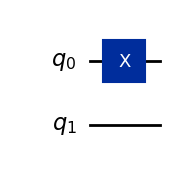

In [19]:
a = QuantumCircuit(2)
a.x(0)
a.draw("mpl")

{'11': 9997, '01': 3}


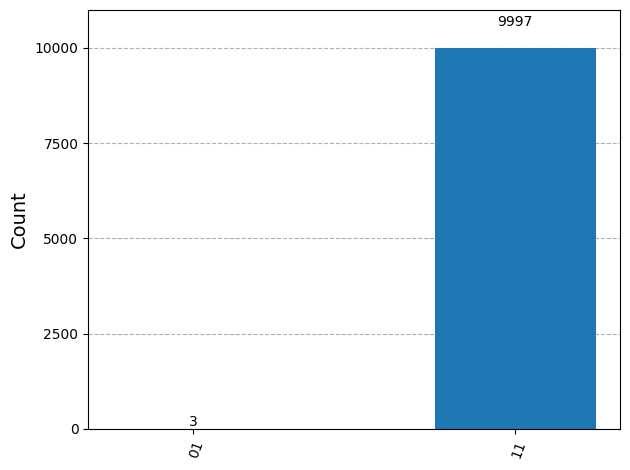

In [20]:
backend1 = AerSimulator()
backend2 = FakeSherbrooke()

result_dict = Experiment(backend1, a, count_of_mes = 10000, 
                                            correction=True, disp=0.5)
print(result_dict)
plot_histogram(result_dict)
# q.draw("mpl")

In [21]:
def accuracy_graph(backend, circuit: QuantumCircuit, min_disp: float, max_disp: float, 
                   step: float, count_of_exp: int):
    x1 = []
    y1 = []
    x2 = []
    y2 = []
    dict_ideal = Experiment(backend=backend, circuit=circuit, count_of_mes=1, 
                            correction=False, disp=0)
    list_ideal = list(dict_ideal)
    ideal_answer = list_ideal[0]
    print(ideal_answer)
    for i in np.arange(min_disp, max_disp, step):
        dict_error_without_correction = Experiment(backend, circuit, count_of_exp, 0, i)
        dict_error_with_correction = Experiment(backend, circuit, count_of_exp, 1, i)
        count_of_right_mes_without_correction = dict_error_without_correction.get(ideal_answer)
        count_of_right_mes_with_correction = dict_error_with_correction.get(ideal_answer)
        x1.append(i)
        x2.append(i)
        accuracy_without_correction = count_of_right_mes_without_correction / count_of_exp
        accuracy_with_correction = count_of_right_mes_with_correction / count_of_exp
        y1.append(accuracy_without_correction)
        y2.append(accuracy_with_correction)
        print('disp = ', i)
        print(accuracy_without_correction, ' ', accuracy_with_correction)
    plt.plot(x1, y1, marker='o', linestyle='-', color='r', label='Без коррекции')
    plt.plot(x2, y2, marker='o', linestyle='-', color='b', label='С коррекцией')
    plt.xlabel('Среднее квадратичное отклонение', fontweight='bold', labelpad=5, fontsize=25)
    plt.ylabel('Точность', fontweight='bold', labelpad=5, fontsize=25)
    plt.title('Зависимость точности от среднего квадратичного отклонения\n' + ideal_answer[:len(ideal_answer) // 2], fontweight='bold', fontsize=16)

    plt.xticks(fontsize=23, fontweight='bold') 
    plt.yticks(fontsize=23, fontweight='bold')

    plt.grid(True)
    font_prop = font_manager.FontProperties(weight='bold', size=25)
    plt.legend(loc='upper left', bbox_to_anchor=(0, -0.05), prop=font_prop)
    #plt.subplots_adjust(bottom=0.2)

    plt.show() 
        



11
disp =  0
1.0   1.0
disp =  1
0.6   0.9
disp =  2
0.6   0.5
disp =  3
0.4   0.5
disp =  4
0.2   0.7
disp =  5
0.5   0.3
disp =  6
0.3   0.3
disp =  7
0.4   0.5
disp =  8
0.2   0.4
disp =  9
0.3   0.5


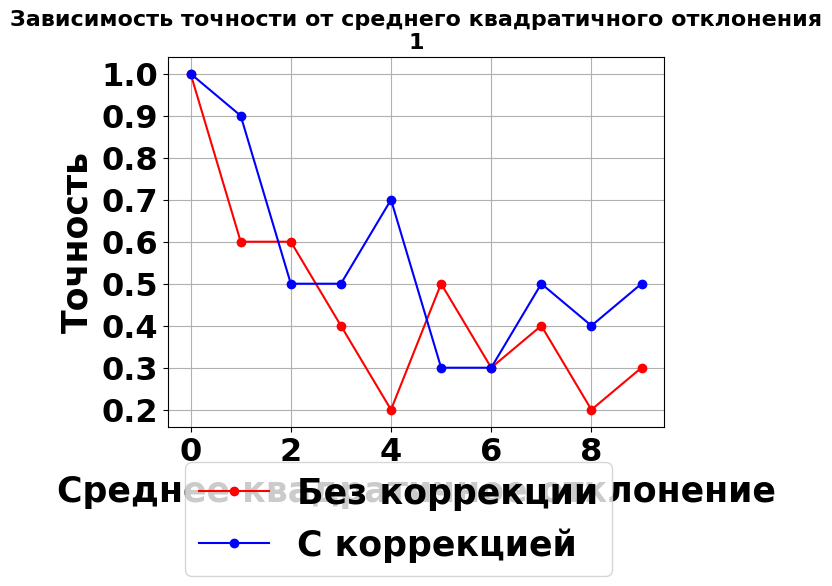

In [22]:
backend = AerSimulator()
accuracy_graph(backend, a, 0, 10, 1, 10)


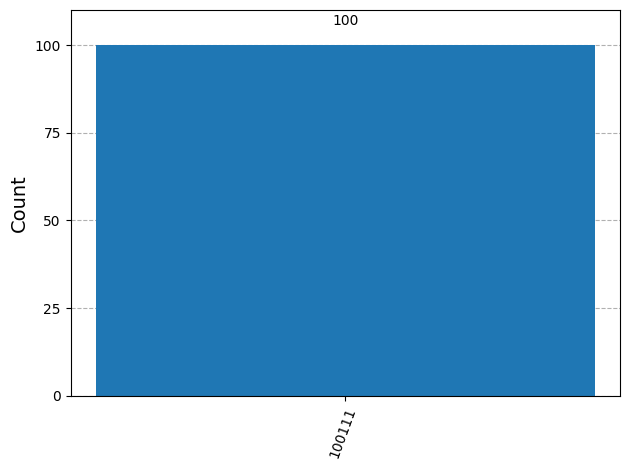

In [23]:
q = QuantumCircuit(4 + 4 + 2)
q.x(0)
q.add_register(ClassicalRegister(6))
for i in range(0, 2):
    q = copy_qubit(q, 2 + i, 2 + i + 2, 2 + i + 2*2)

q = QFT_adder(q, 0, 2, 2, 0)
q = QFT_adder(q, 0, 4, 2, 0)
q = QFT_adder(q, 0, 6, 2, 0)


q.cx(4, 8)
q.cx(6, 8)
q.cx(2, 9)
q.cx(6, 8)
q.measure(8, 0)
q.measure(9, 1)
if q.if_test((0, 1)) and q.if_test((1, 0)):
    q.x(4)
    q.x(8)
if q.if_test((0, 0)) and q.if_test((1, 1)):
    q.x(2)
    q.x(9)
if q.if_test((0, 1)) and q.if_test((1, 1)):
    q.x(6)
    q.x(8)
    q.x(9)



q.cx(5, 8)
q.cx(7, 8)
q.cx(3, 9)
q.cx(7, 8)
q.measure(8, 0)
q.measure(9, 1)
if q.if_test((0, 1)) and q.if_test((1, 0)):
    q.x(5)
    q.x(8)
if q.if_test((0, 0)) and q.if_test((1, 1)):
    q.x(3)
    q.x(9)
if q.if_test((0, 1)) and q.if_test((1, 1)):
    q.x(7)
    q.x(8)
    q.x(9)


q.measure(range(4), range(2, 6))
backend = AerSimulator()
job = backend.run(q, shots=100)
result = job.result().get_counts()
plot_histogram(result)


In [24]:
def QFT_adder_const(
    circuit: QuantumCircuit, 
    const: int, 
    b_start: int, 
    n:int, 
    inverse: bool = False, 
    disp: float = 0
) -> QuantumCircuit:
    sign = 1 if not inverse else -1
    for j in range(n):
      target_qbit = b_start + j
      phase = sign * np.pi * const / (1 << j)
      phase = makeError(phase, disp)
      circuit.p(phase, target_qbit)
    return circuit

In [25]:
def QFT_adder_const_Controlled(
    circuit: QuantumCircuit, 
    controls: list[int],
    const: int,
    b_start: int, 
    n: int,
    inverse: bool = False,
    disp: float = 0
) -> QuantumCircuit:
    sign = 1 if not inverse else -1
    
    for j in range(n):
        target_qbit = b_start + j
        phase = sign * np.pi * const / (1 << j)
        phase = makeError(phase, disp)
        phase_gate = PhaseGate(phase).control(len(controls))
        circuit.append(phase_gate, controls + [target_qbit])
    return circuit

In [26]:
def QFT_adder_const_mod_N(
    circuit: QuantumCircuit, 
    const: int,      # Классическое значение A
    N: int,            # Модуль N
    b_start: int,      # Начальный индекс регистра B (n+1 кубит)
    n: int,       # Размер регистра B (n+1)
    ancilla: int,      # Индекс ансиллы (1 кубит)
    control_1: int,    # Индекс c1
    control_2: int,    # Индекс c2
    disp: float = 0
) -> QuantumCircuit:
    
    msb_qubit = b_start + n - 1
    q.barrier()
    circuit = QFT_adder_const_Controlled(circuit, [control_1, control_2], 
                                         const, b_start, n, False, disp)
    q.barrier()
    circuit = QFT_adder_const(circuit, N, b_start, n, True, disp)
    q.barrier()
    circuit = IQFT(circuit, b_start, b_start + n, disp) 
    q.barrier()
    circuit.cx(msb_qubit, ancilla)
    q.barrier()
    circuit = QFT(circuit, b_start, b_start + n, disp)
    q.barrier()
    circuit = QFT_adder_const_Controlled(circuit, [ancilla], 
                                         N, b_start, n, False, disp)
    q.barrier()
    circuit = QFT_adder_const_Controlled(circuit, [control_1, control_2], 
                                         const, b_start, n, True, disp)
    q.barrier()
    circuit = IQFT(circuit, b_start, b_start + n, disp) 
    q.barrier()
    circuit.x(msb_qubit) 
    circuit.cx(msb_qubit, ancilla)
    circuit.x(msb_qubit) 
    q.barrier()
    circuit = QFT(circuit, b_start, b_start + n, disp)
    q.barrier()
    circuit = QFT_adder_const_Controlled(circuit, [control_1, control_2], 
                                         const, b_start, n, False, disp)
    q.barrier()
    return circuit

пока плохо работает, пытался применять qft от кискита

In [27]:
def QFT_adder_const_with_correction(circuit: QuantumCircuit, const: int, b_start: int, 
            n: int, inverse: bool, disp: float = 0) -> QuantumCircuit:
  new_qubits_count = 2 * circuit.num_qubits
  new_qr = QuantumRegister(new_qubits_count, 'ancilla')
  circuit.add_register(new_qr)
  for i in range(0, n):
    circuit = copy_qubit(circuit, b_start + i, b_start + i + n, b_start + i + 2*n)

  qft_part = QFT(circuit.num_qubits)
  q.append(qft_part, range(circuit.num_qubits))
  for i in range(3):
    circuit = QFT_adder_const(circuit, const, i * n, n, inverse, disp)
  qft_part_inv = qft_part.inverse()
  q.append(qft_part_inv, range(circuit.num_qubits))

  for i in range(0, n):
    circuit = qubit_flip_correction(circuit, b_start + i, b_start + i + n, b_start + i + 2 * n)
  return circuit

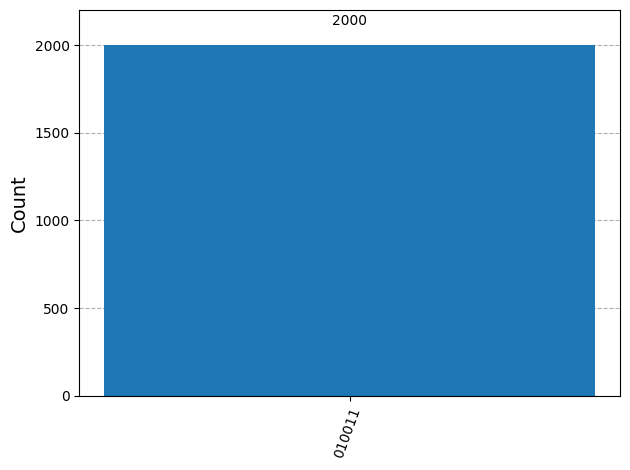

In [ ]:
b_len = 3
num_qbit = 2 + b_len + 1
q = QuantumCircuit(num_qbit)
q.x(0)
q.x(1)
q.x(3)
q = QFT(circuit=q, start=2, n=2 + b_len, disp=0)
q = QFT_adder_const_Controlled(circuit=q, controls=[0, 1], const=4, b_start=2, n=b_len, inverse=False, disp=0)
q = IQFT(circuit=q, start=2, n=2+ b_len, disp=0)



# q.add_register(ClassicalRegister(num_qbit))
# q.measure(range(num_qbit), range(num_qbit))
q.measure_all()
backend = AerSimulator()
job = backend.run(q, shots=2000)
counts = job.result().get_counts()
#q.draw("mpl")
plot_histogram(counts)

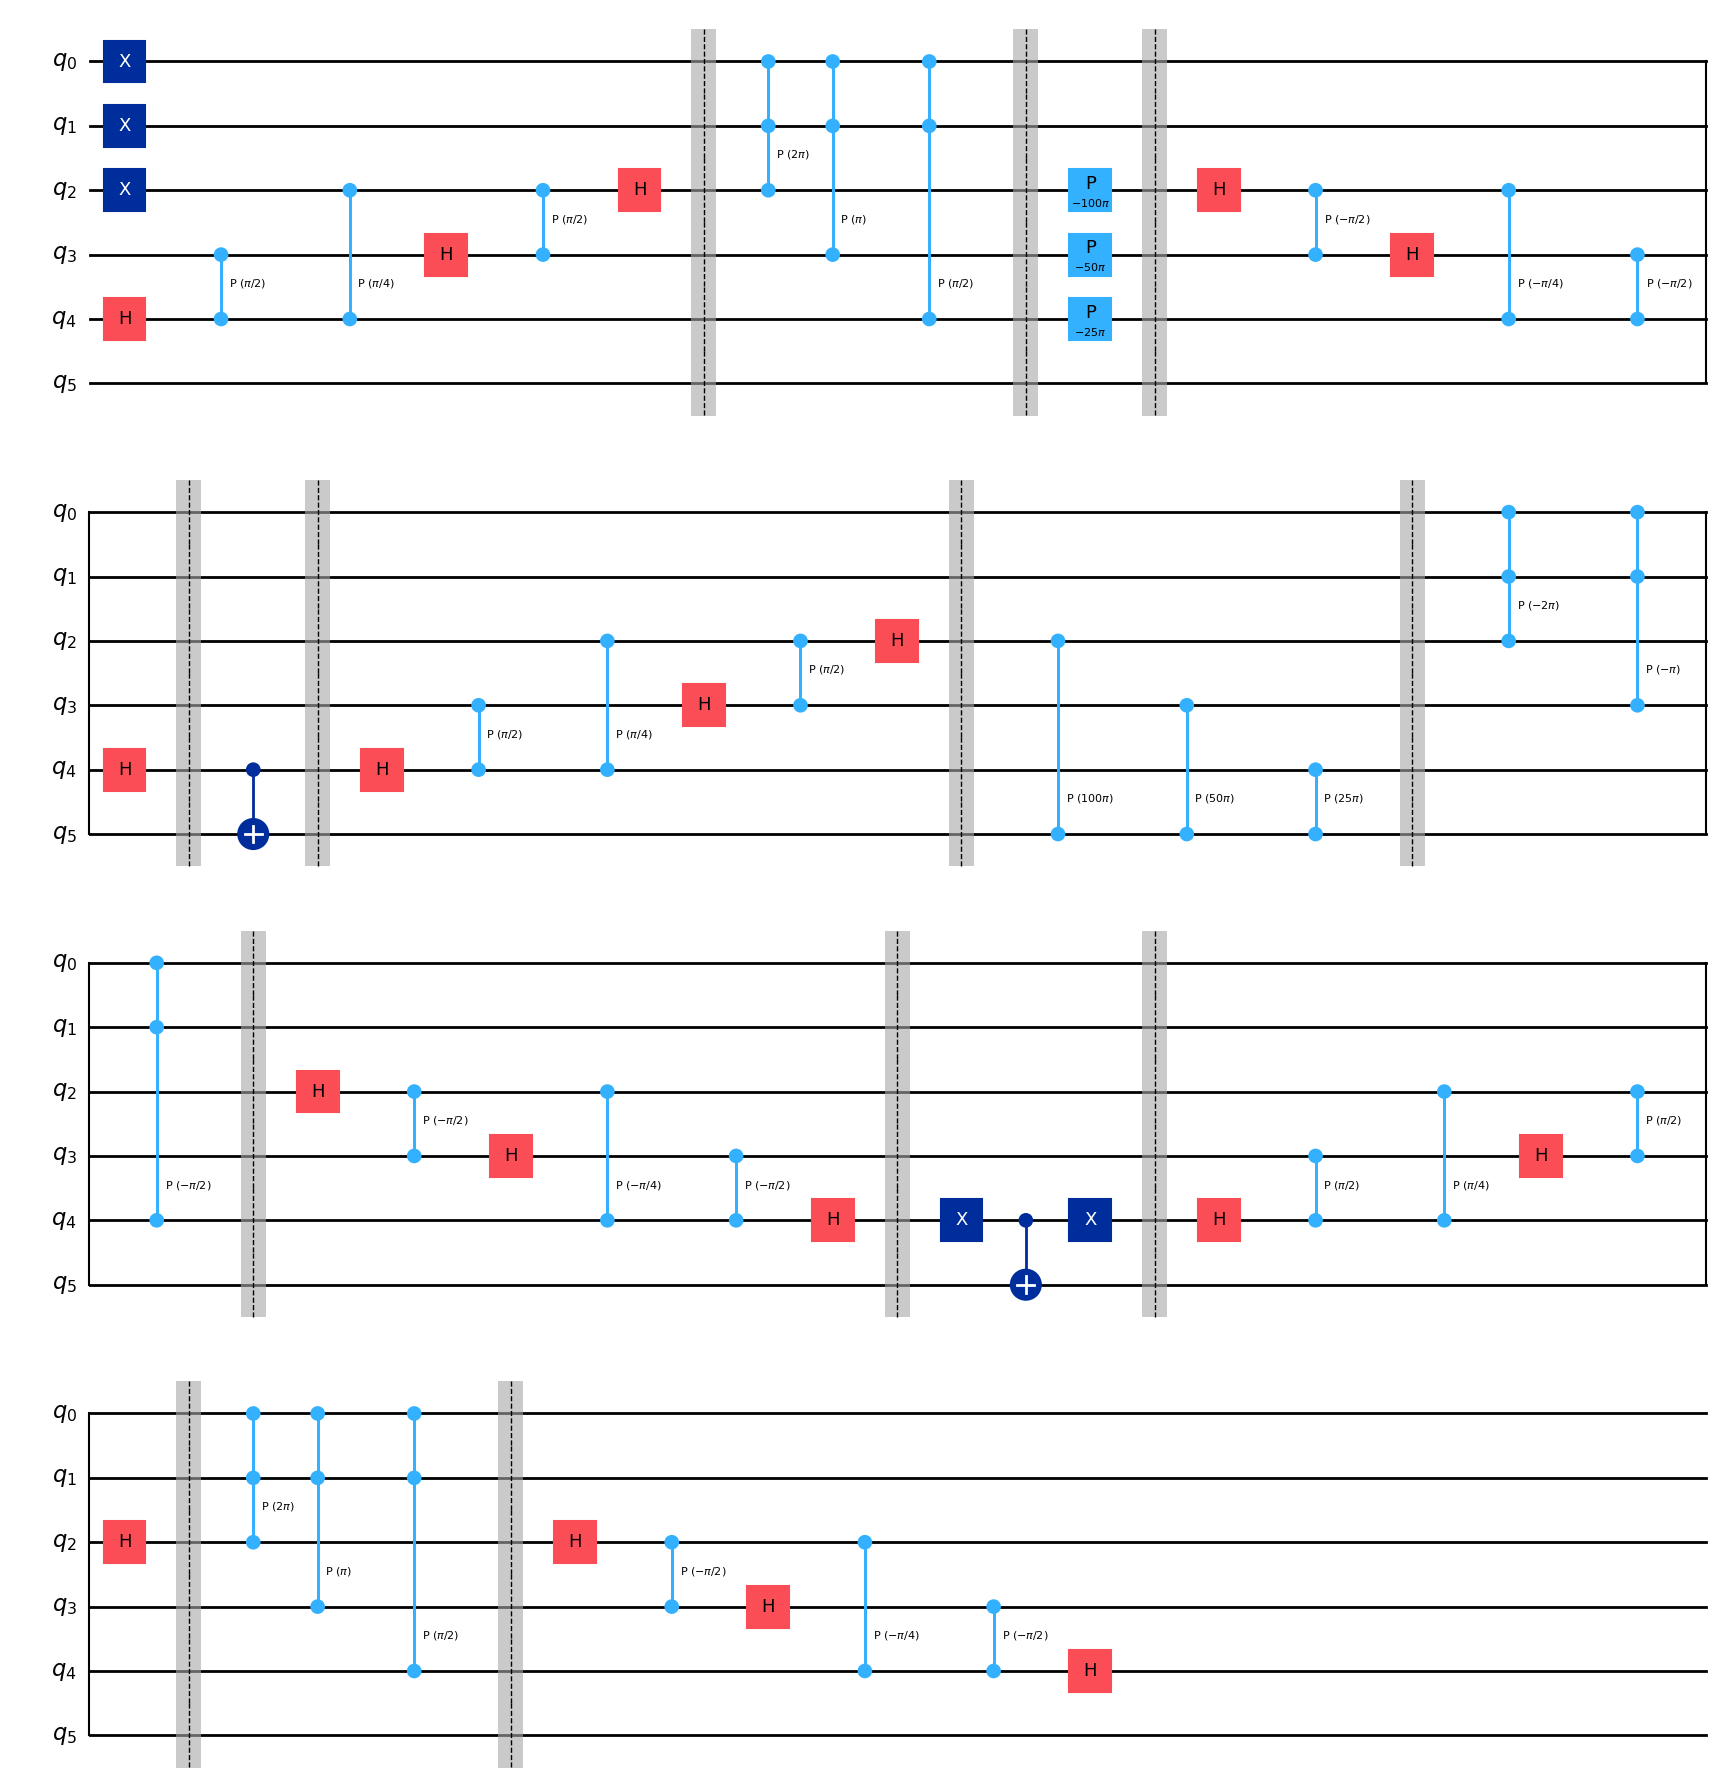

In [29]:
b_len = 3
num_qbit = 2 + b_len + 1
q = QuantumCircuit(num_qbit)
q.x(0)
q.x(1)

q.x(2)

q = QFT(circuit=q, start=2, n=2 + b_len, disp=0)
q = QFT_adder_const_mod_N(circuit=q, const=2, N=100, b_start=2, n=b_len, ancilla=num_qbit - 1, control_1=0, control_2=1, disp=0)
q = IQFT(circuit=q, start=2, n=2 + b_len, disp=0)



q.draw("mpl")


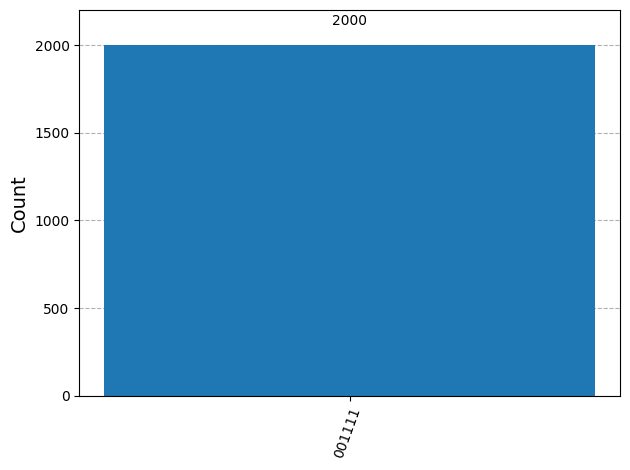

In [30]:
q.measure_all()
backend = AerSimulator()
q_transpile = transpile(q, backend)
job = backend.run(q_transpile, shots=2000)
counts = job.result().get_counts()
plot_histogram(counts)